In [83]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [128]:
import seaborn as sns
sns.set_style(
    #style='darkgrid', 
    sns.axes_style("white")
    #rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80


### Hyperparameters initialisation:

In [85]:
#dimension of the vector beta_i: it has p features we want to learn. Here p=beta_dim
beta_dim =100

In [86]:
#The input x is a scalar and here its dimension is 1
input_dim = 1

In [87]:
#number of rbf centers
num_phi_rbf = 100

#sigma of the radial basis function
phi_rbf_sigma =1.0 

#we need to learn phi using a NN. We assume it has 2 hidden layers, each with 10 neurons
phi_hidden_layer_size = 20

In [89]:
#dimension of the latent variable z that embeds beta
z_dim = 20

In [90]:
# Gives the numbers of betas to learn
num_training_funcs = 1000

In [91]:
#each function f_i is evaluated at K locations. Here K=num_eval_points
#this is the K in the piVAE paper: number of locations where we evaluate each fct/each path:
num_eval_points = 20

In [92]:
#the encoder and the decoder parts each have 3 layers
encoder_h_dim_1 = 512
encoder_h_dim_2 = 512
encoder_h_dim_3 = 128

decoder_h_dim_1 = 128
decoder_h_dim_2 = 128
decoder_h_dim_3 = 128

In [93]:
s_lims = [-5., 5.]

In [94]:
def generate_sine_dataset():
    s_append = []
    sine_value_at_K_append = []
    
    for fct_id in range(num_training_funcs):
        s = np.random.uniform(s_lims[0], s_lims[1], size=(num_eval_points, 1))
               
        amplitude = np.random.uniform(1.0, 5.0)
      
        phase = np.random.uniform(0, 2 * np.pi)      
        
        sin_s = amplitude * np.sin(s*5 - phase)
        
        s_append.append(s)
        
        sine_value_at_K_append.append(sin_s)
        
    return np.array(s_append), np.array(sine_value_at_K_append)

In [95]:
dataset_sine_s, dataset_sine_x=generate_sine_dataset()
dataset_sine_s.shape

(1000, 20, 1)

In [96]:
dataset_sine_x.shape

(1000, 20, 1)

In [97]:
dataset_sine_x = np.transpose(dataset_sine_x, (0, 2, 1))
dataset_sine_x.shape

(1000, 1, 20)

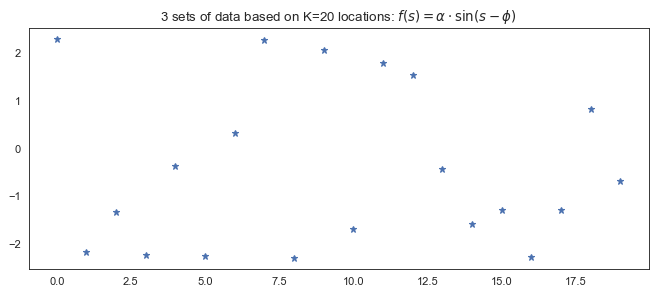

In [107]:
for i in range(1):
    plt.plot(dataset_sine_x[i,0,:], '*')
plt.title("3 sets of data based on K=20 locations: " r'$f(s)=\alpha \cdot \sin(s-\phi)$')
plt.show()

In [99]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()                                  
    
        self.phi_rbf_centers = nn.Parameter(torch.tensor(
            np.random.uniform(s_lims[0], s_lims[1],
            size=(num_phi_rbf, input_dim))))
        self.phi_nn_1 = nn.Linear(num_phi_rbf, phi_hidden_layer_size)
        self.phi_nn_2 = nn.Linear(phi_hidden_layer_size, beta_dim)

        self.encoder_nn_1 = nn.Linear(beta_dim, encoder_h_dim_1)
        self.encoder_nn_2 = nn.Linear(encoder_h_dim_1, encoder_h_dim_2)
        self.encoder_nn_3 = nn.Linear(encoder_h_dim_2, encoder_h_dim_3)
        self.encoder_nn_4 = nn.Linear(encoder_h_dim_3, z_dim * 2)

        self.decoder_nn_1 = nn.Linear(z_dim, decoder_h_dim_1)
        self.decoder_nn_2 = nn.Linear(decoder_h_dim_1, decoder_h_dim_2)
        self.decoder_nn_3 = nn.Linear(decoder_h_dim_2, decoder_h_dim_3)
        self.decoder_nn_4 = nn.Linear(decoder_h_dim_3, beta_dim)

        # self.betas = nn.Parameter(torch.ones(num_training_funcs, beta_dim))
        self.betas = nn.Parameter(torch.tensor(
            np.random.uniform(-1, 1, size=(num_training_funcs, beta_dim))
        ))

        self.normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)


    def Phi(self, input):
        #print('input size')
        #print(input.shape)
        
        input_expand = torch.unsqueeze(input, 1)
        #print('input_expand size')
        #print(input_expand.shape)
        
        #print('self.phi_rbf_centers size')
        #print(self.phi_rbf_centers.shape)
        
        phi_expand = torch.unsqueeze(self.phi_rbf_centers, 0)
        #print('phi_expand size')
        #print(phi_expand.shape)
        M1 = input_expand - phi_expand
        M2 = torch.sum(M1 ** 2, 2)

        M3 = torch.exp(-M2/phi_rbf_sigma)
        M4 = F.sigmoid(self.phi_nn_1(M3))
        M5 = self.phi_nn_2(M4)
        return M5
     

    def encoder(self, input):
        
        # input (batch x beta_dim) output ((batch x z_dim), (batch x z_dim))
        M1 = F.relu(self.encoder_nn_1(input))
        M2 = F.relu(self.encoder_nn_2(M1))
        M3 = F.relu(self.encoder_nn_3(M2))
        M4 = self.encoder_nn_4(M3)
        z_mean = M4[:, 0:z_dim]
        z_std = torch.exp(M4[:, z_dim:]) # needs to be positive
        return z_mean, z_std

    def decoder(self, input):
        # input (batch x z_dim) output (batch x beta_dim)
        M1 = F.relu(self.decoder_nn_1(input))
        M2 = F.relu(self.decoder_nn_2(M1))
        M3 = F.relu(self.decoder_nn_3(M2))
        M4 = self.decoder_nn_4(M3)
        return M4
    
    
    

    def get_loss_term_1(self, fct_id, s, x):
        batch_size = s.shape[0]
        phi_s = self.Phi(s)        
        original_beta_fct_id = self.betas[fct_id, :]        
        x_enc = torch.matmul(phi_s, original_beta_fct_id)                
        loss_term_1 = (x - x_enc)**2
        
        return torch.mean(loss_term_1)

       
    def get_loss_term_2(self, fct_id, s, x): 
        phi_s = self.Phi(s)    
        original_beta_fct_id = self.betas[fct_id, :]        
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))       
        z_sample = z_mean.double() + z_std.double() * self.normal_sampler.rsample((1, z_dim)).double()                    
        beta_hat = self.decoder(z_sample)        
        x_dec = torch.matmul(phi_s, beta_hat.squeeze())         
        loss_term_2 = (x - x_dec)**2
        
        return torch.mean(loss_term_2)

    
    def get_loss_term_3(self, fct_id, kl_factor):        
        original_beta_fct_id = self.betas[fct_id, :]  
        z_mean, z_std = self.encoder(original_beta_fct_id.unsqueeze(0))    
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),dim=1)       
        loss_term_3 = kl_factor * (loss_term_3/z_dim)
        return loss_term_3       
        

   
    def get_loss(self, function_id, s, x, kl_factor, print_breakdown=False, 
        return_breakdown=False):
        batch_size = s.shape[0]

        phi_s = self.Phi(s)
        beta = self.betas[function_id, :]
        x_enc = torch.matmul(phi_s, beta)

        loss_term_1 = (x - x_enc)**2

        z_mean, z_std = self.encoder(beta.unsqueeze(0))
        z_sample = z_mean + z_std * self.normal_sampler.rsample((1, z_dim))
        beta_hat = self.decoder(z_sample)
        x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
        loss_term_2 = (x - x_dec)**2

     
        loss_term_3 = 0.5 * torch.sum(z_std**2 + z_mean**2 - 1 - torch.log(z_std**2),
            dim=1)
        loss_term_3 = kl_factor * (loss_term_3/z_dim)

        if print_breakdown:
            print("1", torch.mean(loss_term_1))
            print("2", torch.mean(loss_term_2))
            print("3", loss_term_3)

        if return_breakdown == False:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3
        else:
            return torch.mean(loss_term_1 + loss_term_2) + loss_term_3, \
                torch.mean(loss_term_1), torch.mean(loss_term_2), loss_term_3

    
    # Compute decoded OU values at location points s
    # when the value of the latent variable z is given by the posterior
    def evaluate_decoded_x_at_given_z(self, z, s, return_beta_hat=False):        
        phi_s = self.Phi(s)       
        beta_hat = self.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        if not return_beta_hat:
            return x_dec
        else:
            return x_dec, beta_hat
   

    # This function returns decoded values of sine functions when z ~N(0,1). 
    # Generate samples from the pivae, with z ~ N(0,1)
    def generate_x_samples_from_pivae(self, s, num_samples):               
        z_samples = self.normal_sampler.rsample((num_samples, z_dim)).double()        
        beta_hats = self.decoder(z_samples)
        phi_s = self.Phi(s)
        x_dec = torch.matmul(beta_hats.unsqueeze(1).unsqueeze(1),
            phi_s.unsqueeze(2).unsqueeze(0))
        x_dec = x_dec.squeeze()

        return x_dec

In [100]:
pivae_model=Model().double()
pivae_model

Model(
  (phi_nn_1): Linear(in_features=100, out_features=20, bias=True)
  (phi_nn_2): Linear(in_features=20, out_features=100, bias=True)
  (encoder_nn_1): Linear(in_features=100, out_features=512, bias=True)
  (encoder_nn_2): Linear(in_features=512, out_features=512, bias=True)
  (encoder_nn_3): Linear(in_features=512, out_features=128, bias=True)
  (encoder_nn_4): Linear(in_features=128, out_features=40, bias=True)
  (decoder_nn_1): Linear(in_features=20, out_features=128, bias=True)
  (decoder_nn_2): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_3): Linear(in_features=128, out_features=128, bias=True)
  (decoder_nn_4): Linear(in_features=128, out_features=100, bias=True)
)

In [101]:
#KL divergence factor: 
kl_factor=1.0

#learning rate
learning_rate=0.001

#this is the number of input functions used in training
num_funcs_to_consider = 50
current_max = 1000
interval = 3

total_nbr_epochs=300

In [102]:
optimizer=torch.optim.Adam(pivae_model.parameters(), lr=learning_rate)

In [103]:
Loss_per_epoch_append = []
L1_per_epoch_append = []
L2_per_epoch_append = []
L3_per_epoch_append = []

In [104]:
for epoch_id in range(total_nbr_epochs):
    
    print("epoch id:", epoch_id)
    l1s = []
    l2s = []
    l3s = []
    losses=[]
    

    
    for function_id in range(num_funcs_to_consider):
        optimizer.zero_grad()
        input_points = torch.tensor(dataset_sine_s[function_id])
        x_vals = torch.tensor(dataset_sine_x[function_id])
        loss, l1, l2, l3 = pivae_model.get_loss(function_id, input_points, x_vals,
            kl_factor, return_breakdown=True)
        loss.backward()
        optimizer.step()
        l1s.append(l1.detach().cpu().numpy())
        l2s.append(l2.detach().cpu().numpy())
        l3s.append(l3.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

    if epoch_id % interval == 0:
        num_funcs_to_consider = min(num_funcs_to_consider+1, current_max)
        
    L1=np.mean(np.array(l1s))
    L2= np.mean(np.array(l2s))
    L3=np.mean(np.array(l3s))
    Loss=np.mean(np.array(losses))
       

    print("L1", L1,
        "L2", L2,
        "L3", L3,
        "Loss", Loss,
        "num funcs", num_funcs_to_consider)
    
    Loss_per_epoch_append.append(Loss)
    L1_per_epoch_append.append(L1)
    L2_per_epoch_append.append(L2)
    L3_per_epoch_append.append(L3)

print("Loss_per_epoch_append:")
print(Loss_per_epoch_append)

print("L1_per_epoch_append")
print(L1_per_epoch_append)

print("L2_per_epoch_append")
print(L2_per_epoch_append)

print("L3_per_epoch_append")
print(L3_per_epoch_append)


    

epoch id: 0
L1 8.792574475822807 L2 5.466770808194234 L3 0.005207783707253786 Loss 14.264553067724293 num funcs 51
epoch id: 1
L1 6.356803946888753 L2 5.36191915131479 L3 0.0027607099077253837 Loss 11.72148380811127 num funcs 51
epoch id: 2
L1 5.629830864953308 L2 5.370012210071166 L3 0.002138286793044285 Loss 11.001981361817519 num funcs 51
epoch id: 3
L1 5.333154226856336 L2 5.362035120252506 L3 0.0019083736147539232 Loss 10.697097720723594 num funcs 52
epoch id: 4
L1 5.278626078977739 L2 5.43944775778238 L3 0.002034739340455103 Loss 10.720108576100575 num funcs 52
epoch id: 5
L1 5.179429651644098 L2 5.4573735619561425 L3 0.0017276797340814419 Loss 10.638530893334321 num funcs 52
epoch id: 6
L1 5.111673276211539 L2 5.4534385289805085 L3 0.0022227640519689204 Loss 10.567334569244016 num funcs 53
epoch id: 7
L1 5.112170943400291 L2 5.400173917400407 L3 0.0022824274561410803 Loss 10.51462728825684 num funcs 53
epoch id: 8
L1 4.982156343758068 L2 5.373060757298257 L3 0.012715992999809573

L1 2.8462671486955036 L2 5.0022433738186205 L3 0.14546807133874823 Loss 7.99397859385287 num funcs 75
epoch id: 73
L1 2.8142211145835447 L2 4.992128807014361 L3 0.1895812970566583 Loss 7.995931218654563 num funcs 75
epoch id: 74
L1 2.7897266107026657 L2 4.823514022843392 L3 0.17861046061468067 Loss 7.79185109416074 num funcs 75
epoch id: 75
L1 2.719924986874115 L2 4.62565823675893 L3 0.20885531011982333 Loss 7.554438533752869 num funcs 76
epoch id: 76
L1 2.7986286453068123 L2 4.8937753325366815 L3 0.1348398138739312 Loss 7.827243791717424 num funcs 76
epoch id: 77
L1 2.7338177509656387 L2 4.5718251149221025 L3 0.1883757011152492 Loss 7.49401856700299 num funcs 76
epoch id: 78
L1 2.661801434354624 L2 4.409995026232693 L3 0.20201417568628013 Loss 7.273810636273597 num funcs 77
epoch id: 79
L1 2.6070129614191577 L2 4.170465242597415 L3 0.220119477899662 Loss 6.997597681916237 num funcs 77
epoch id: 80
L1 2.53992887470792 L2 4.069098512604846 L3 0.17710611288881817 Loss 6.786133500201584 n

L1 0.5678330116087591 L2 0.5175543350327386 L3 0.2929803096250803 Loss 1.378367656266578 num funcs 98
epoch id: 144
L1 0.509875672240496 L2 0.4672564572016012 L3 0.2932070865314324 Loss 1.2703392159735294 num funcs 99
epoch id: 145
L1 0.489494589037901 L2 0.42570539330666834 L3 0.2927498766185587 Loss 1.2079498589631281 num funcs 99
epoch id: 146
L1 0.4419467243241417 L2 0.3921548549059353 L3 0.28272749087908067 Loss 1.1168290701091579 num funcs 99
epoch id: 147
L1 0.40769461579860294 L2 0.3409104842283981 L3 0.28429799947077816 Loss 1.0329030994977795 num funcs 100
epoch id: 148
L1 0.44263831704552814 L2 0.46168621441919816 L3 0.2727231678369846 Loss 1.177047699301711 num funcs 100
epoch id: 149
L1 0.5258226917223681 L2 0.5125465862922494 L3 0.2807169047129163 Loss 1.319086182727534 num funcs 100
epoch id: 150
L1 0.5203352170396189 L2 0.45143009888858643 L3 0.2726416899317449 Loss 1.2444070058599506 num funcs 101
epoch id: 151
L1 0.5072765143223475 L2 0.42608531883734135 L3 0.28049790

L1 0.2556301004713055 L2 0.33362462762382644 L3 0.2547905638784836 Loss 0.8440452919736157 num funcs 121
epoch id: 213
L1 0.24630338275303118 L2 0.36321312744605727 L3 0.24714485785803877 Loss 0.856661368057127 num funcs 122
epoch id: 214
L1 0.28787350475287327 L2 0.44144038731395785 L3 0.2454429364080632 Loss 0.9747568284748944 num funcs 122
epoch id: 215
L1 0.25365951711220125 L2 0.3854539173575265 L3 0.24665619277642262 Loss 0.8857696272461504 num funcs 122
epoch id: 216
L1 0.2008716661083412 L2 0.33472432306212524 L3 0.24822178028022834 Loss 0.7838177694506948 num funcs 123
epoch id: 217
L1 0.28242484306344745 L2 0.33118689867598783 L3 0.2505728263441103 Loss 0.8641845680835456 num funcs 123
epoch id: 218
L1 0.27514154230050963 L2 0.3104497060681053 L3 0.2423351149722911 Loss 0.8279263633409062 num funcs 123
epoch id: 219
L1 0.24392716763033448 L2 0.2416337949768175 L3 0.2645398937304407 Loss 0.7501008563375927 num funcs 124
epoch id: 220
L1 0.21555110940013786 L2 0.27328325378777 

L1 0.2242037105959801 L2 0.33985762971321637 L3 0.2521635846696018 Loss 0.8162249249787982 num funcs 144
epoch id: 282
L1 0.1969736048171799 L2 0.31625823936660247 L3 0.2461282520284673 Loss 0.7593600962122498 num funcs 145
epoch id: 283
L1 0.1965787743263887 L2 0.2132603400435502 L3 0.24727515348768594 Loss 0.6571142678576248 num funcs 145
epoch id: 284
L1 0.17338318614709125 L2 0.20867186264250456 L3 0.24234563409785714 Loss 0.6244006828874529 num funcs 145
epoch id: 285
L1 0.16384565904605408 L2 0.1903358521993816 L3 0.23097108554819037 Loss 0.585152596793626 num funcs 146
epoch id: 286
L1 0.18297361584621488 L2 0.2555114862012007 L3 0.22815158158743706 Loss 0.6666366836348526 num funcs 146
epoch id: 287
L1 0.19716730712564373 L2 0.24431022456548993 L3 0.22961261528278087 Loss 0.6710901469739146 num funcs 146
epoch id: 288
L1 0.22967798274137832 L2 0.315065573591534 L3 0.2415496520089608 Loss 0.7862932083418729 num funcs 147
epoch id: 289
L1 0.2918757029201896 L2 0.46975570773536834

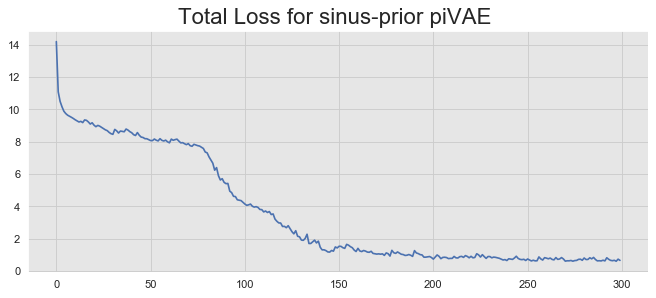

In [69]:
plt.plot(Loss_per_epoch_append)
plt.title("Total Loss for sinus-prior piVAE ", fontsize=20 )
plt.show()

Text(0.5, -0.2, '$L_1=\\frac{1}{\\sigma^2_0}[x-\\beta^T\\cdot\\Phi(s)]^2}$')

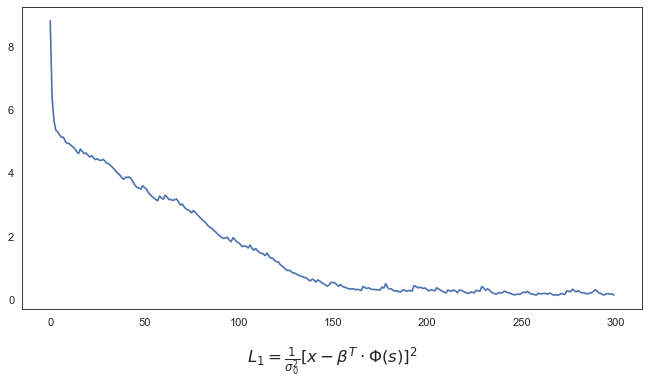

In [154]:
plt.plot(L1_per_epoch_append)
plt.title(r'$L_1=\frac{1}{\sigma^2_0}[x-\beta^T\cdot\Phi(s)]^2}$',fontsize=15, y=-0.2)

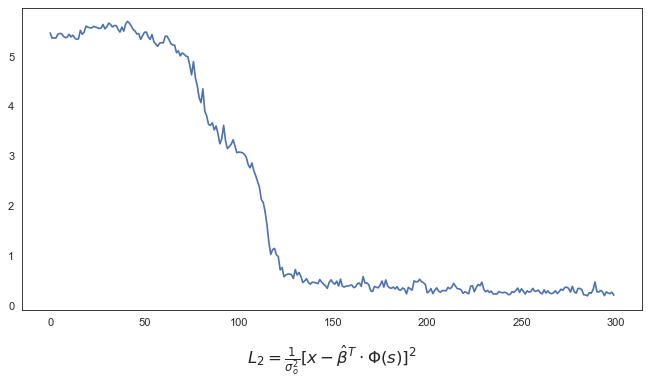

In [155]:
plt.plot(L2_per_epoch_append)
plt.title(r'$L_2=\frac{1}{\sigma^2_o}[x-\hat\beta^T\cdot\Phi(s)]^2}$',fontsize=15, y=-0.2)
plt.show()

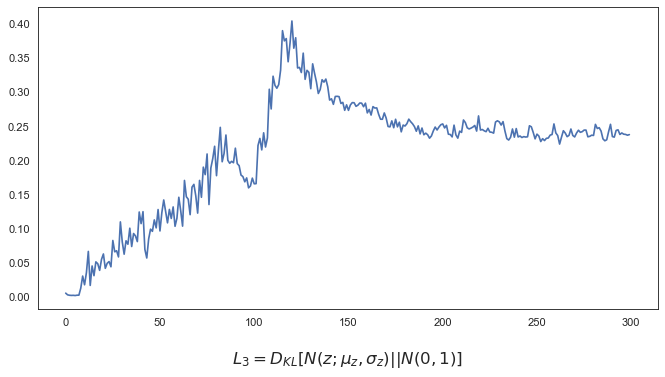

In [156]:
plt.plot(L3_per_epoch_append)
plt.title(r'$L_3=D_{KL}[N(z; \mu_z, \sigma_z)||N(0,1)]$', fontsize=15, y=-0.2)
plt.show()

### Generate Sine samples from piVAE using $z \sim N(0,1):$

In [122]:
num_piVAE_samples=3

In [123]:
test_pts_for_plot_tensor = torch.arange(-5., 5., 0.05).double() 
test_pts_for_plot_tensor.shape    

torch.Size([200])

In [124]:
test_pts_for_plot_np = np.arange(-5., 5., 0.05)
test_pts_for_plot_np.shape    

(200,)

In [125]:
piVAE_samples_tensor = pivae_model.generate_x_samples_from_pivae(
                                test_pts_for_plot_tensor.unsqueeze(1),5)

In [126]:
piVAE_samples_np = np.array(piVAE_samples_tensor.detach().numpy())

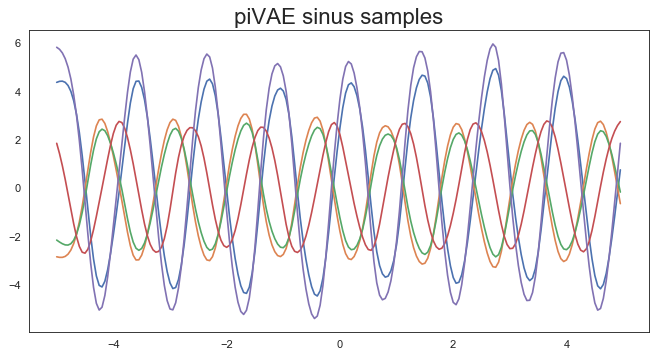

In [129]:
for i in range(piVAE_samples_np.shape[0]):
    plt.plot(test_pts_for_plot_tensor.detach().cpu().numpy(), piVAE_samples_np[i, :])
plt.title("piVAE sinus samples", fontsize=20)
plt.show()

In [32]:
def plot_decoded_x_samples_from_z_posterior(model, z_samples_from_post, s_star_tensor, x_star_tensor):    
            
    for i in range(z_samples_from_post.shape[0]):
        # Evaluates decoded x at location test_points when the value of the latent z_samples are given
        decoded_x = model.evaluate_decoded_Sine_at_given_z(z_samples_from_post[i,:],
                                                           test_pts_for_plot_tensor.unsqueeze(1))

        plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='black')

    
    plt.scatter(s_star_tensor.detach().numpy(), x_star_tensor.detach().numpy(), s=1000, marker="+")
    plt.show()

In [33]:
# Compute a quantity proportional to p(z|x, s) where x and s are new test points
def get_unnormalized_log_posterior(model, s, x, z, obs_sigma):        
        
    #z ~ N(0,1)
    log_prior = -0.5 * torch.sum(z**2)

    phi_s = model.Phi(s)

    beta_hat = model.decoder(z)
    
    x_dec = torch.matmul(phi_s, beta_hat.squeeze()) 
    
    x=torch.squeeze(x)
    
    #GAUSSIAN LL 
    log_likelihoods = (-1 / (2 * obs_sigma**2)) * (x_dec - x)**2

    return log_prior + torch.sum(log_likelihoods)

In [34]:
def draw_MCMC_z_samples(model, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor):
        
    z = z_starting_point
    #create a tensor of zeros to contain the z values that are going to be sampled
    z_samples = torch.zeros((nbr_z_samples, z_dim)).double()

    acceptance_prob_sum = 0

    for z_sample in range(nbr_z_samples):
        if(z_sample %1000==0):
            print("sample_id",z_sample)
              
        #z_p ~ N(z,MH_sigma**2)
        z_proposed = z + torch.randn_like(z) * MH_proposal_sigma**2            

        log_posterior_z = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                         x_star_tensor, z, obs_sigma)

        log_posterior_z_proposed = get_unnormalized_log_posterior(model, s_star_tensor, 
                                                                x_star_tensor, z_proposed, obs_sigma)

        MH_ratio = torch.exp(log_posterior_z_proposed - log_posterior_z)

        acceptance_prob = torch.min(torch.tensor(1.0).double(), MH_ratio)

        u = torch.rand(1).double()

        if u < acceptance_prob:
            z = z_proposed

        z_samples[z_sample, :] = z

        acceptance_prob_sum += acceptance_prob.detach()

    print("mean acceptance prob", acceptance_prob_sum/nbr_z_samples)
    return z_samples


In [131]:
#amplitude = np.random.uniform(1.0, 5.0)
#phase = np.random.uniform(0, 2 * np.pi)      
#sin_s = amplitude * np.sin(s*5 - phase)

amplitude_grd_truth=2.0
phase_grd_truth=np.pi

def ground_truth_sinus_fct(locations):
    return amplitude_grd_truth * np.sin(5.0*locations - phase_grd_truth)

In [132]:
s_star_np=np.arange(-5.,5,0.1)
s_star_np.shape

(100,)

In [133]:
x_star_np=ground_truth_sinus_fct(s_star_np)
x_star_np.shape

(100,)

In [134]:
#create a data frame with 2 columns: one for the s_star and one for the x_star
df=pd.DataFrame(s_star_np)
df['x_star']=x_star_np
df['s_star']=s_star_np
#df

In [135]:
#select observations from ground truth
nbr_obs=10
s_obs=np.zeros(nbr_obs)
x_obs=np.zeros(nbr_obs)

k=int(len(s_star_np)/nbr_obs)
print(k)
for i in range(nbr_obs):
    s_obs[i]=df['s_star'][k*i]
    x_obs[i]=df['x_star'][k*i]
s_obs.shape

10


(10,)

In [136]:
#add noise to ground truth
sigma_noise=0.1
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_obs))
epsilon.shape
y_obs=np.zeros(nbr_obs)
y_obs.shape
y_obs=x_obs +epsilon
y_obs.shape

(10,)

nbr observations: 10


Text(0.5, 1.0, 'Ground truth OU prior and 10 observations')

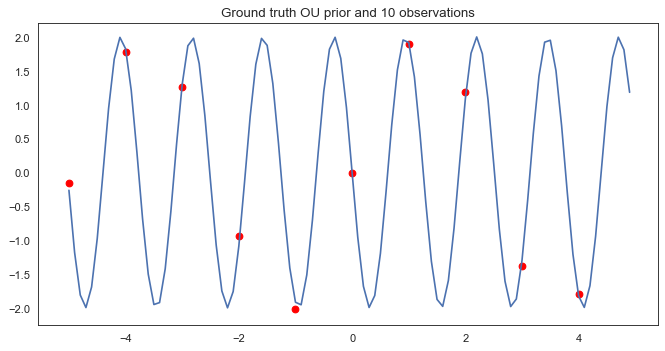

In [137]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='r')
print("nbr observations:", len(y_obs))
length=len(y_obs)
plt.title('Ground truth OU prior and 10 observations')
#plt.show()

In [138]:
z = torch.ones((z_dim,)).double()

#when MH_proposal_sigma increases the credible interval gets too narrow 
#when obs_sigma decreases: the mean posterior gets closer to the ground truth

nbr_iter=10000
MH_proposal_sigma=1.
obs_sigma=1.5

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_obs).unsqueeze(1), 
                                        torch.tensor(y_obs))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.0084, dtype=torch.float64)


In [139]:
mcmc_selected_samples_run1 = mcmc_samples[1000::100,:]

In [140]:
mcmc_selected_samples_run1.shape

torch.Size([90, 20])

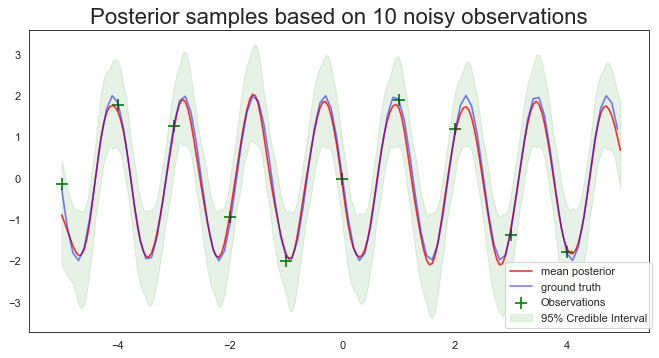

In [153]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_x_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    #plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.975,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.025,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.8, color='r', label='mean posterior')
    
plt.scatter(s_obs, y_obs, color="g", s=100, marker="+", label="Observations")
plt.plot(s_star_np, x_star_np, alpha=0.5, color='b', label="ground truth")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(bbox_to_anchor=(0.76, 0.25))
plt.title("Posterior samples based on 10 noisy observations", fontsize=20)
plt.show()

In [48]:
#select 20 new points from the dataframe
nbr_new_star=5
s_obs_20=np.zeros(nbr_new_star)
x_obs_20=np.zeros(nbr_new_star)
for i in range(nbr_new_star):
    s_obs_20[i]=df['s_star'][15*i+3]
    x_obs_20[i]=df['x_star'][15*i+3]
x_obs_20.shape

(5,)

Text(0.5, 1.0, 'Ground truth OU prior')

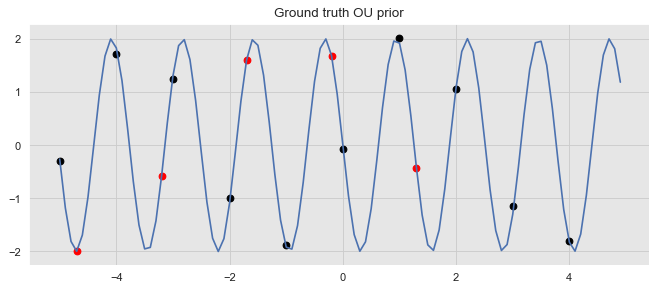

In [49]:
plt.plot(s_star_np, x_star_np, label='Ground truth')
plt.scatter(s_obs, y_obs, color='k')
plt.scatter(s_obs_20, x_obs_20,color="r")
#plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

#plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Ground truth OU prior')
#plt.show()

In [157]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples
nbr_iter_2=10000
z = torch.ones((z_dim,)).double()

mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter_2, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_obs_20).unsqueeze(1), torch.tensor(x_obs_20))

sample_id 0
sample_id 1000
sample_id 2000
sample_id 3000
sample_id 4000
sample_id 5000
sample_id 6000
sample_id 7000
sample_id 8000
sample_id 9000
mean acceptance prob tensor(0.0207, dtype=torch.float64)


In [158]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::100,:]

In [159]:
mcmc_selected_samples_run2.shape

torch.Size([90, 20])

In [160]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [161]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_obs_20).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

(5,)

In [162]:
#nbr_new_star=5
RMSE=np.sqrt(np.sum((new_star_mean_post - x_obs_20)**2/nbr_new_star))
RMSE

0.1147913864444204

In [ ]:
nbr_star_pts=100
s_star_np=np.linspace(-4.9,4.9,nbr_star_pts)
s_star_np.shape

In [ ]:
x_star_np=ground_truth_sinus_fct(s_star_np)
x_star_np.shape

In [ ]:
#add noise to ground truth
sigma_noise=0.4
epsilon = np.random.normal(loc=0, scale=sigma_noise, size=len(x_star_np))
epsilon.shape
y_obs=np.zeros(len(x_star_np))
y_obs.shape
y_obs=x_star_np +epsilon

y_obs.shape

In [ ]:
plt.plot(test_pts_for_plot_np, ground_truth_sinus_fct(test_pts_for_plot_np), label='Ground truth')
plt.scatter(s_star_np, y_obs, color='r', label='Noisy Observations')

plt.legend(loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
z = torch.ones((z_dim,)).double()

In [ ]:
#self, nbr_z_samples, z_starting_point, MH_proposal_sigma, obs_sigma, s_star_tensor, x_star_tensor)
nbr_iter=10000
MH_proposal_sigma=0.05
obs_sigma=0.01

mcmc_samples = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, torch.tensor(s_star_np).unsqueeze(1), 
                                        torch.tensor(y_obs))

In [ ]:
mcmc_selected_samples_run1 = mcmc_samples[1000::500,:]

In [ ]:
mcmc_selected_samples_run1.shape

In [ ]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run1)):
        
    decoded_x = pivae_model.evaluate_decoded_Sine_at_given_z(mcmc_selected_samples_run1[i,:], 
                                                             test_pts_for_plot_tensor.unsqueeze(1))
    
    plt.plot(test_pts_for_plot_np, decoded_x.detach().numpy(), alpha=0.1, color='grey')
    
    all_dec_x.append(decoded_x.detach().numpy())  
      
mean_dec_x=np.mean(np.array(all_dec_x), axis=0)

quantile_0975_dec_x=np.quantile(np.array(all_dec_x),0.001,axis=0)

quantile_0025_dec_x=np.quantile(np.array(all_dec_x),0.999,axis=0)
    
plt.plot(test_pts_for_plot_np, mean_dec_x, alpha=0.2, color='blue', label='mean posterior')
    
plt.scatter(s_star_np, x_star_np, color="red", s=100, marker="+", label="Observations")

plt.fill_between(test_pts_for_plot_np, quantile_0025_dec_x, quantile_0975_dec_x,
                    facecolor="green",
                    color='green', 
                    alpha=0.1, label = '95% Credible Interval') 

plt.legend(loc="lower right")
plt.title("Posterior samples for PiVAE on sinus functions")
plt.show()

In [ ]:
#from the same function that generated 4 observation points, get new points 
#see the value of both Pi-VAE and Gp posterior. 
#Compute them against known function and report the RMSE. 

In [ ]:
#get 2 new points from the ground truth function:
nbr_new_star_pts=20
s_star_new_np=np.linspace(-4.,4., nbr_new_star_pts)
s_star_new_np

In [ ]:
x_star_new_np=ground_truth_sinus_fct(s_star_new_np)
x_star_new_np

In [ ]:
#now we need to compute the posterior at these 20 new points
#the way to do this is to run MCMC on these samples and take the mean posterior of these samples

mcmc_samples2 = draw_MCMC_z_samples(pivae_model, nbr_iter, z, MH_proposal_sigma, obs_sigma, 
                                   torch.tensor(s_star_new_np).unsqueeze(1), torch.tensor(x_star_new_np))

In [ ]:
mcmc_selected_samples_run2 = mcmc_samples2[1000::500,:]

In [ ]:
mcmc_selected_samples_run2.shape

In [ ]:
def eval_decoded_x_at_given_z(model, z, s):        
        phi_s = model.Phi(s)       
        beta_hat = model.decoder(z)        
        x_dec = torch.matmul(phi_s, beta_hat)        
        return x_dec   

In [ ]:
all_dec_x=[]    
for i in range(len(mcmc_selected_samples_run2)):
    decoded_new_x = eval_decoded_x_at_given_z(pivae_model, mcmc_selected_samples_run2[i,:], 
                                                             torch.tensor(s_star_new_np).unsqueeze(1))

    all_dec_x.append(decoded_new_x.detach().numpy())  
      
new_star_mean_post=np.mean(np.array(all_dec_x), axis=0)
new_star_mean_post.shape

In [ ]:
RMSE=np.sqrt(np.sum((new_star_mean_post-x_star_new_np)**2/nbr_new_star_pts))
RMSE

In [ ]:
def check_beta(model, id):
    
    test_points = torch.arange(-5, 5, 0.1).reshape(100, 1)
    
    phi_s = model.Phi(test_points)
    
    beta = model.betas[id, :]
    
    x_encs = torch.matmul(phi_s, beta)
    
    z_mean, z_std = model.encoder(beta.unsqueeze(0))
    
    beta_hat = model.decoder(z_mean)
    
    x_decs = torch.matmul(beta_hat, torch.transpose(phi_s, 0, 1))
    
    #plot encoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy(), x_encs.detach().cpu().numpy(), color='red')
    
    #plot decoded x's against test locations
    plt.plot(test_points.detach().cpu().numpy().reshape(100), x_decs.detach().cpu().numpy().reshape(100), color='green')
    
    plt.scatter(dataset_sine_s[id].reshape(num_eval_points), dataset_sine_x[id].reshape(num_eval_points))
    plt.title("Reconstruction of training data")
    plt.show()

In [ ]:
# ------ Check reconstructions of training data -------
for i in range(2):
    check_beta(pivae_model, i)

#%%